# Restricted Boltzmann Machines in R

## MNIST Data-Set

Load the MNIST digit recognition dataset into R http://yann.lecun.com/exdb/mnist/
assume you have all 4 files and gunzip'd them creates train\$n, train\$x, train\$y  and test\$n, test\$x, test\$y
e.g. train\$x is a 60000 x 784 matrix, each row is one digit (28x28)
call:  show\_digit(train$x[5,]) to see a digit.

* Snippet authory: **Brendan O'Connor** - https://gist.github.com/39760 - anyall.org

In [1]:
load_mnist <- function()
{
    load_image_file <- function(filename)
    {
        ret = list();
        f = file(filename,'rb');
        readBin(f,'integer',n=1,size=4,endian='big');
        ret$n = readBin(f,'integer',n=1,size=4,endian='big');
        nrow = readBin(f,'integer',n=1,size=4,endian='big');
        ncol = readBin(f,'integer',n=1,size=4,endian='big');
        x = readBin(f,'integer',n=ret$n*nrow*ncol,size=1,signed=F);
        ret$x = matrix(x, ncol=nrow*ncol, byrow=T);
        close(f);
        ret;
    }
    load_label_file <- function(filename)
    {
        f = file(filename,'rb');
        readBin(f,'integer',n=1,size=4,endian='big');
        n = readBin(f,'integer',n=1,size=4,endian='big');
        y = readBin(f,'integer',n=n,size=1,signed=F);
        close(f);
        y;
    }
    train <<- load_image_file('./datasets/train-images.idx3-ubyte');
    test <<- load_image_file('./datasets/t10k-images.idx3-ubyte');

    train$y <<- load_label_file('./datasets/train-labels.idx1-ubyte');
    test$y <<- load_label_file('./datasets/t10k-labels.idx1-ubyte');
}

show_digit <- function(arr784, col=gray(12:1/12), ...)
{
    image(matrix(arr784, nrow=28)[,28:1], col=col, ...);
}

* Load **MNIST**
* Normalize: X = (X - min) / (max - min) => X = (X - 0) / (255 - 0) => X = X / 255.
* Setup training data with digit and pixel values with 60/40 split for train/cv.

In [2]:
train <- data.frame();
test <- data.frame();

load_mnist();

train$x <- train$x / 255;

inTrain <- data.frame(y=train$y, train$x);
inTrain$y <- as.factor(inTrain$y);
trainIndex <- sample(x=1:length(inTrain$y),size=length(inTrain$y) * 0.6);
training <- inTrain[trainIndex,];
cv <- inTrain[-trainIndex,];

Draw a Digit

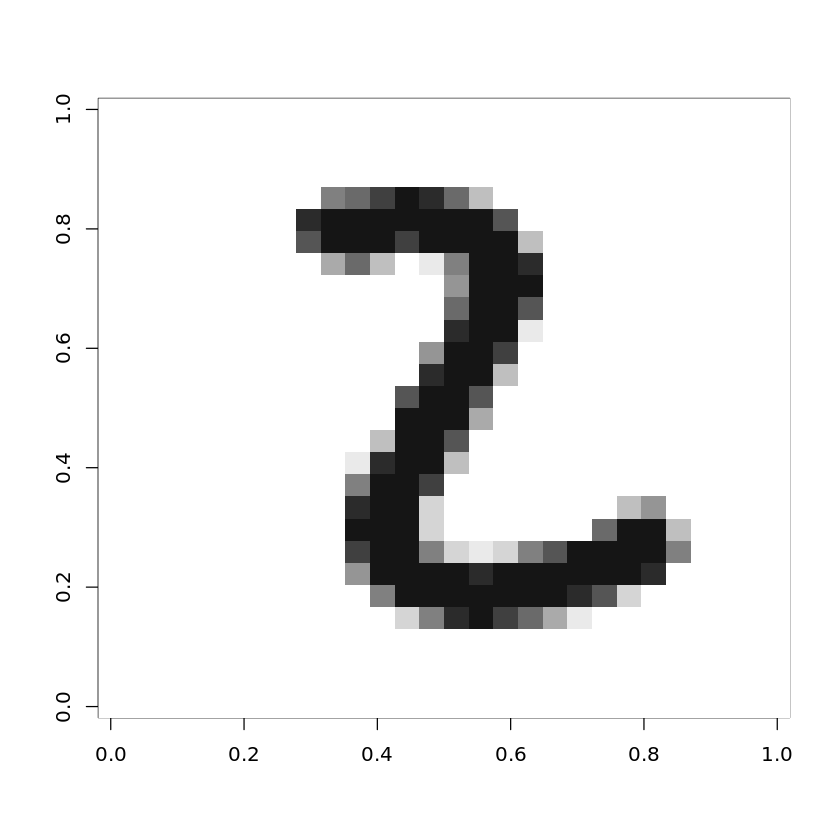

In [3]:
show_digit(as.matrix(training[5,2:785]))

In [4]:
# Requires caret and kernlab (from source better than deb)
#library(caret)

Train a SVM and Predict a digit, then show

In [5]:
if (FALSE)
{
    opt.warn <- getOption("warn");
    options(warn = -1);

    # SVM. 95/94.
    fit <- train(y ~ ., data = head(training, 1000), method = 'svmRadial', tuneGrid = data.frame(sigma=0.0107249, C=1))
    results <- predict(fit, newdata = head(cv, 1000))
    confusionMatrix(results, head(cv$y, 1000))

    # Predict the digit.
    predict(fit, newdata = training[5,])

    # Check the actual answer for the digit.
    training[5,1]

    options(warn = opt.warn);
}

In [6]:
training.num <- data.matrix(training)

In [7]:
training.num[1:3,];

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
8257,8,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0
40521,4,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0
33151,9,0,0,0,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0


## RBM Implementation

Inspired by the implementations from:
* **David Buchaca** : https://github.com/davidbp/connectionist
* **Andrew Landgraf** : https://www.r-bloggers.com/restricted-boltzmann-machines-in-r/
* **Graham Taylor** : http://www.uoguelph.ca/~gwtaylor/

In [8]:
## Function to produce Normal Samples
sample_normal <- function(dims, mean = 0, sd = 1)
{
    array(rnorm(n = prod(dims), mean = mean, sd = sd), dims);
}

## Function to produce Bernoulli Samples
sample_bernoulli <- function(mat)
{
    dims <- dim(mat);
    array(rbinom(n = prod(dims), size = 1, prob = c(mat)), dims);
}

## Function to produce the Sigmoid
sigmoid_func <- function(mat)
{
    1 / (1 + exp(-mat));
}

## Operator to add dimension-wise vectors to matrices
`%+%` <- function(mat, vec)
{
    retval <- NULL;
    tryCatch(
        expr = { retval <- if (dim(mat)[1] == length(vec)) t(t(mat) + vec) else mat + vec; },
        warning = function(w) { print(paste("WARNING: ", w, sep = "")); },
        error = function(e) { print(paste("ERROR: Cannot sum mat and vec", e, sep = "\n")); }
    );
    retval;
}

### RBM creation and operation functions

In [9]:
## Restricted Boltzmann Machine (RBM). Constructor
create_rbm <- function(n_visible, n_hidden, rand_seed = 42, mu = 0, sigma = 0.3)
{
    set.seed(rand_seed);
    
    W <- 0.01 * sample_normal(c(n_hidden, n_visible), mean = mu, sd = sigma);
    vbias <- 0.01 * as.vector(sample_normal(n_visible, mean = mu, sd = sigma));
    hbias <- 0.01 * as.vector(sample_normal(n_hidden, mean = mu, sd = sigma));
    
    velocity <- list(W = array(0, dim(W)), v = rep(0, length(vbias)), h = rep(0, length(hbias)));
    
    list(n_visible = n_visible, n_hidden = n_hidden, W = W, hbias = hbias, vbias = vbias, velocity = velocity);
}

### This function infers state of hidden units given visible units
visible_state_to_hidden_probabilities <- function(rbm, visible_state)
{
    h.mean <- sigmoid_func((rbm$W %*% visible_state) %+% rbm$hbias);
    h.sample <- sample_bernoulli(h.mean);

    list(mean = h.mean, sample = h.sample);
}

## This function infers state of visible units given hidden units
hidden_state_to_visible_probabilities <- function(rbm, hidden_state)
{
    v.mean <- sigmoid_func((t(rbm$W) %*% hidden_state) %+% rbm$vbias);
    v.sample <- sample_bernoulli(v.mean);

    list(mean = v.mean, sample = v.sample);
}

## This functions implements one step of CD-k
##  param input: matrix input from batch data (n_vis x n_seq)
##  param lr: learning rate used to train the RBM
##  param k: number of Gibbs steps to do in CD-k
##  param momentum: value for momentum coefficient on learning
cdk_rbm <- function(rbm, input, lr, k = 1, momentum = 0.1)
{  
    # compute positive phase (awake)
    ph <- visible_state_to_hidden_probabilities(rbm, input);

    # perform negative phase (asleep)
    nh <- ph;
    for (i in 1:k)
    {
        nv <- hidden_state_to_visible_probabilities(rbm, nh[["sample"]]);
        nh <- visible_state_to_hidden_probabilities(rbm, nv[["sample"]]);
    }

    # determine gradients on CRBM parameters
    Delta_W <- (ph[["sample"]] %*% t(input)) - (nh[["mean"]] %*% t(nv[["sample"]]));
    Delta_v <- rowMeans(input - nv[["sample"]]);
    Delta_h <- rowMeans(ph[["sample"]] - nh[["mean"]]);
    
    rbm$velocity[["W"]] <- rbm$velocity[["W"]] * momentum + lr * Delta_W;
    rbm$velocity[["v"]] <- rbm$velocity[["v"]] * momentum + lr * Delta_v;
    rbm$velocity[["h"]] <- rbm$velocity[["h"]] * momentum + lr * Delta_h;
    
    # update weights
    rbm$W <- rbm$W + rbm$velocity[["W"]];
    rbm$vbias <- rbm$vbias + rbm$velocity[["v"]];
    rbm$hbias <- rbm$hbias + rbm$velocity[["h"]];

    # approximation to the reconstruction error: sum over dimensions, mean over cases
    list(rbm = rbm, recon = mean(rowSums(`^`(input - nv[["mean"]],2))));
}

### How to Train your RBM

In [10]:
## Function to train the RBM
##  param dataset: loaded dataset (rows = examples, cols = features)
##  param learning_rate: learning rate used for training the RBM
##  param training_epochs: number of epochs used for training
##  param batch_size: size of a batch used to train the RBM
train_rbm <- function (dataset, batch_size = 100,
                       n_hidden = 100, training_epochs = 300,
                       learning_rate = 1e-4, momentum = 0.5)
{
    set.seed(123);

    n_train_batches <- ceiling(nrow(dataset) / batch_size);
    n_dim <- ncol(dataset);
    
    batchdata <- t(dataset);
   
    # shuffle indices
    permindex <- sample(1:nrow(dataset),nrow(dataset));

    # construct the CRBM object
    rbm <- create_rbm(n_visible = n_dim, n_hidden = n_hidden, rand_seed = 123);

    start_time <- Sys.time();
 
    # go through the training epochs and training set
    for (epoch in 1:training_epochs)
    {
        st1 <- Sys.time();
        
        mean_cost <- NULL;
        for (batch_index in 1:n_train_batches)
        {
            idx.aux.ini <- (((batch_index - 1) * batch_size) + 1);
            idx.aux.fin <- idx.aux.ini + batch_size - 1;
            if (idx.aux.fin > length(permindex)) break;
            data_idx <- permindex[idx.aux.ini:idx.aux.fin];

            input <- batchdata[,data_idx];
                       
            # get the cost and the gradient corresponding to one step of CD-k
            aux <- cdk_rbm(rbm, input, lr = learning_rate, momentum = momentum, k = 1);
            this_cost <- aux$recon;
            rbm <- aux$rbm;

            mean_cost <- c(mean_cost, this_cost);
        }
        
        et1 <- Sys.time();
        message(paste('[Time Spent: ',round(as.numeric(et1 - st1),2),'] Training epoch ',epoch,', cost is ',mean(mean_cost, na.rm = TRUE),sep=""));
    }

    end_time <- Sys.time();
    print(paste('Training took', (end_time - start_time),'minutes',sep=" "));

    rbm;
}

### Train a RBM with the MNIST dataset

In [11]:
rbm <- train_rbm(
    n_hidden = 30,
    dataset = training.num[,2:785],
    learning_rate = 1e-3,
    training_epochs = 10,
    batch_size = 10,
    momentum = 0.5
);

[Time Spent: 7.04] Training epoch 1, cost is 0.498056242428024
[Time Spent: 6.74] Training epoch 2, cost is 0.359767515023094
[Time Spent: 6.98] Training epoch 3, cost is 0.343904784891341
[Time Spent: 6.76] Training epoch 4, cost is 0.338087465046044
[Time Spent: 6.91] Training epoch 5, cost is 0.33543199599176
[Time Spent: 6.78] Training epoch 6, cost is 0.334091432080134
[Time Spent: 6.76] Training epoch 7, cost is 0.333306487570479
[Time Spent: 6.87] Training epoch 8, cost is 0.332972782722825
[Time Spent: 6.79] Training epoch 9, cost is 0.333256875372304
[Time Spent: 6.76] Training epoch 10, cost is 0.333506106360457


[1] "Training took 1.13997204701106 minutes"


In [12]:
rbm$W[1:3,]

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
-0.9820291,-1.028845,-1.049830,-0.9983515,-1.031876,-0.981797,-1.015455,-1.009391,-1.037396,-0.9780813,,-0.9933553,-0.9915938,-0.9974561,-1.009957,-0.9860719,-1.002047,-1.052405,-1.030581,-1.032664,-0.9944317
-1.1851042,-1.226506,-1.225579,-1.2068366,-1.255543,-1.198533,-1.200484,-1.210879,-1.181401,-1.2214677,,-1.2564400,-1.2721336,-1.1883628,-1.181851,-1.1436604,-1.211648,-1.172957,-1.302081,-1.230771,-1.2220392
-1.0983460,-1.071422,-1.042312,-1.0985218,-1.076999,-1.070403,-1.078603,-1.055663,-1.036005,-1.0498783,,-1.0753433,-1.0714057,-1.0887965,-1.057740,-1.1037815,-1.083012,-1.077205,-1.064766,-1.132798,-1.0603252


### Display the learned results

In [13]:
library(ggplot2);
library(reshape2);


Attaching package: 'ggplot2'

The following object is masked _by_ '.GlobalEnv':

    %+%



In [14]:
weights <- rbm$W;
colnames(weights) <-  NULL;
mw <- melt(weights);

In [15]:
mw$Var3 <- floor((mw$Var2 - 1)/28) + 1;
mw$Var2 <- (mw$Var2 - 1) %% 28 + 1;
mw$Var3 <- 29 - mw$Var3;

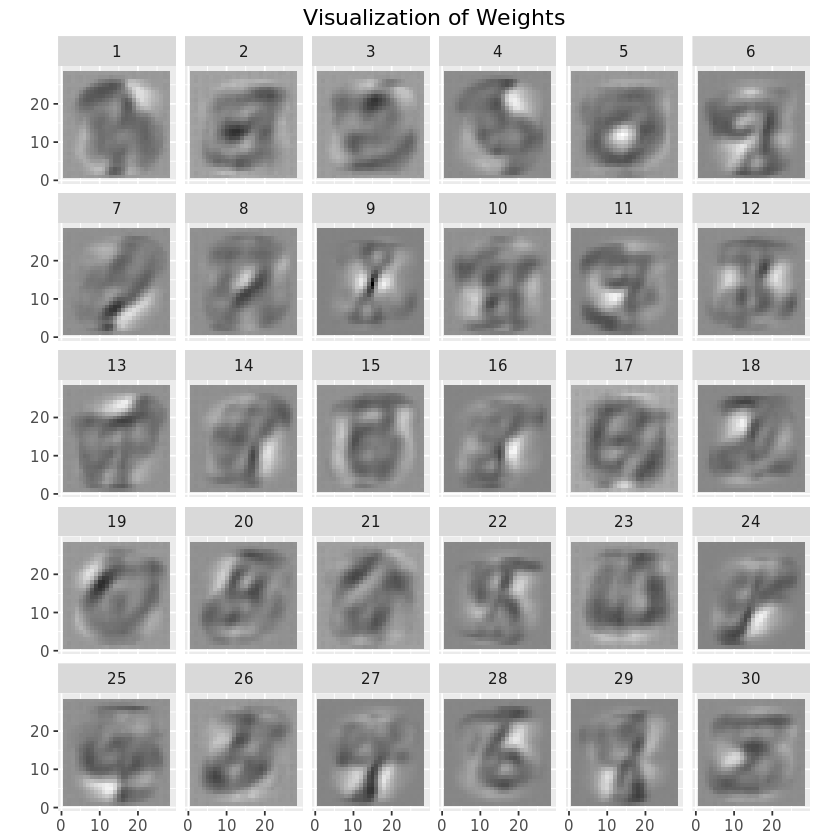

In [16]:
ggplot(data = mw) +
geom_tile(aes(Var2, Var3, fill = value)) +
facet_wrap(~Var1, nrow = 5) +
scale_fill_continuous(low = 'white', high = 'black') +
coord_equal() +
labs(x = NULL, y = NULL, title = "Visualization of Weights") +
theme(legend.position = "none")

### Prediction and Reconstruction

Reconstruction of all the data-set, to see how the RBM sees each number.

In [17]:
# Reconstruction
act.input <- sigmoid_func((rbm$W %*% t(training.num[,2:785])) + rbm$hbias);
rec.input <- sigmoid_func((t(rbm$W) %*% act.input) + rbm$vbias);

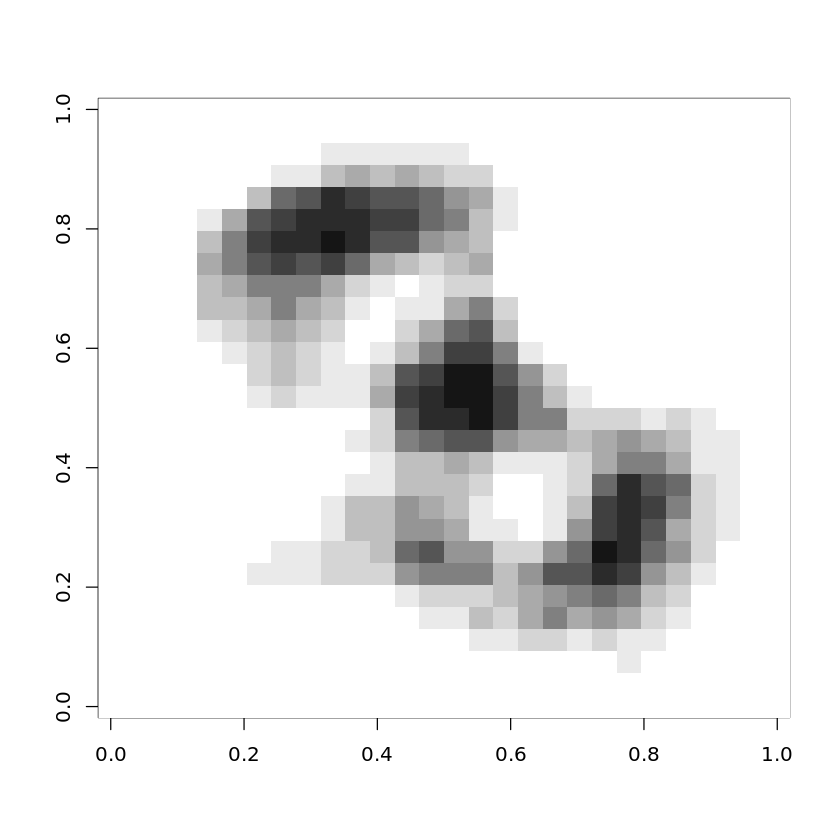

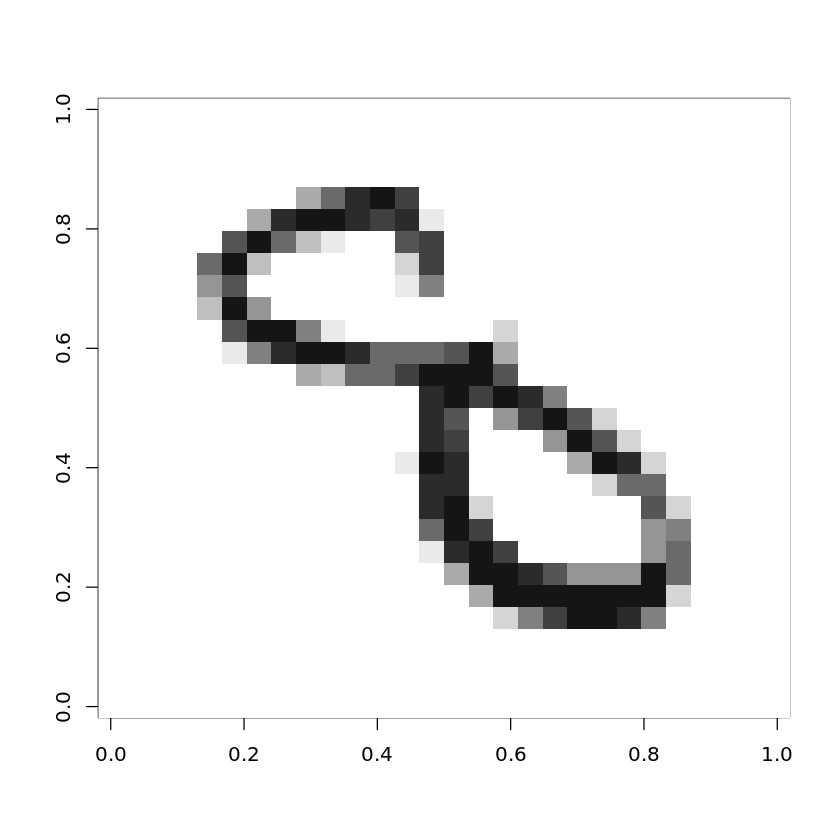

In [18]:
show_digit(as.matrix(rec.input[,3]))
show_digit(as.matrix(training.num[3,2:785]))